### **Escolha do Problema**
**Objetivo do Trabalho**  
O objetivo principal deste projeto é prever se um lançamento resultará em cesto ou não, com base nas coordenadas de lançamento e outras características associadas aos lançamentos na WNBA. Este é um problema de classificação, pois a variável alvo é categórica (cesto ou não).

**Classificação:**
1. **Natureza da Variável Alvo**:
   - A variável alvo é categórica (binária), indicando se o lançamento foi bem-sucedido (`1`) ou não (`0`).
   - A tarefa de classificação é apropriada para prever categorias discretas.

2. **Exploração de Fatores Determinantes**:
   - Utilizar técnicas de classificação permite compreender quais características, como posição do lançamento, distância e ângulo, influenciam diretamente no sucesso do arremesso.
   - Isso auxilia na identificação de padrões de sucesso, podendo gerar insights úteis para treinamento ou estratégia de jogo.

Essa abordagem é consistente com os objetivos de análise preditiva em esportes e pode fornecer insights interpretáveis com o uso de técnicas de inteligência artificial explicável (XAI).

### Imports

In [516]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# **Task 1**

## Exploração dos dados

In [517]:
df = pd.read_csv('wnba-shots-2021.csv')
df.head()

,game_id,game_play_number,desc,shot_type,made_shot,shot_value,coordinate_x,coordinate_y,shooting_team,home_team_name,away_team_name,home_score,away_score,qtr,quarter_seconds_remaining,game_seconds_remaining
0,401391650,4,Shatori Walker-Kimbrough blocks Destanni Hende...,Jump Shot,False,0,37,9,Indiana,Washington,Indiana,0,0,1,571,2371
1,401391650,7,Elena Delle Donne misses two point shot,Turnaround Bank Jump Shot,False,0,12,0,Washington,Washington,Indiana,0,0,1,551,2351
2,401391650,9,Tiffany Mitchell makes 4-foot layup (Destanni ...,Cutting Layup Shot,True,2,29,2,Indiana,Washington,Indiana,0,2,1,538,2338
3,401391650,10,Natasha Cloud makes driving layup,Driving Layup Shot,True,2,22,0,Washington,Washington,Indiana,2,2,1,524,2324
4,401391650,11,Tiffany Mitchell makes 26-foot three point jum...,Jump Shot,True,3,9,21,Indiana,Washington,Indiana,2,5,1,512,2312


In [518]:
print("Informações do Dataset:")
print(df.info())

Informações do Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41497 entries, 0 to 41496
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   game_id                    41497 non-null  int64 
 1   game_play_number           41497 non-null  int64 
 2   desc                       41497 non-null  object
 3   shot_type                  41497 non-null  object
 4   made_shot                  41497 non-null  bool  
 5   shot_value                 41497 non-null  int64 
 6   coordinate_x               41497 non-null  int64 
 7   coordinate_y               41497 non-null  int64 
 8   shooting_team              41497 non-null  object
 9   home_team_name             41497 non-null  object
 10  away_team_name             41497 non-null  object
 11  home_score                 41497 non-null  int64 
 12  away_score                 41497 non-null  int64 
 13  qtr                        41497 non-

In [519]:
print("\nValores ausentes por coluna:")
print(df.isnull().sum())


Valores ausentes por coluna:
game_id                      0
game_play_number             0
desc                         0
shot_type                    0
made_shot                    0
shot_value                   0
coordinate_x                 0
coordinate_y                 0
shooting_team                0
home_team_name               0
away_team_name               0
home_score                   0
away_score                   0
qtr                          0
quarter_seconds_remaining    0
game_seconds_remaining       0
dtype: int64


In [520]:
max_coordinate_x = df['coordinate_x'].max()
max_coordinate_y = df['coordinate_y'].max()
min_coordinate_x = df['coordinate_x'].min()
min_coordinate_y = df['coordinate_y'].min()
print(f'Valor máximos:')
print(f'coordinate_x: {max_coordinate_x}')
print(f'coordinate_y: {max_coordinate_y}')
print(f'Valor mínimos:')
print(f'coordinate_x: {min_coordinate_x}')
print(f'coordinate_y: {min_coordinate_y}')

Valor máximos:
coordinate_x: 50
coordinate_y: 81
Valor mínimos:
coordinate_x: -214748340
coordinate_y: -214748365


   Aqui reparamos que provávelmente há uma constante nestes valores negativos de coordenadas.

In [521]:
# em quantas linhas o coordinate_x é negativo?
negatives = df[df['coordinate_x'] < 0]
print(f'Quantidade de linhas com coordinate_x negativo: {len(negatives)}')

# em quantas linhas o coordinate_y é negativo?
negatives = df[df['coordinate_y'] < 0]
print(f'Quantidade de linhas com coordinate_y negativo: {len(negatives)}')

# verifica se dentro dessas linhas o shot_type tem 'Free Throw' no nome
negatives = df[(df['coordinate_x'] < 0) & (df['coordinate_y'] < 0) & (df['shot_type'].str.contains('Free Throw'))]
print(f'Quantidade de linhas onde o coordinate_x e coordinate_y são negativos e o shot_type contém "Free Throw": {len(negatives)}')

Quantidade de linhas com coordinate_x negativo: 8633
Quantidade de linhas com coordinate_y negativo: 9390
Quantidade de linhas onde o coordinate_x e coordinate_y são negativos e o shot_type contém "Free Throw": 8633


   Comprovamos então que estes valores foram dados a lançamentos livres. De forma a estarem distinguidos entre todos os lançamentos corridos de jogo.

In [522]:
print("\nDuplicados:", df.duplicated().sum())


Duplicados: 0


## Exploração e Visualização dos dados

### Distribuições

#### Distribuição da variável alvo

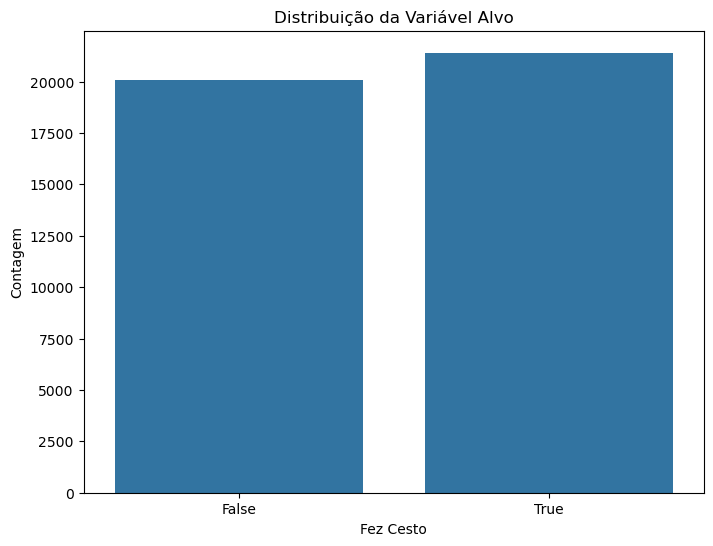

In [523]:
plt.figure(figsize=(8, 6))
sns.countplot(x='made_shot', data=df)
plt.title('Distribuição da Variável Alvo')
plt.xlabel('Fez Cesto')
plt.ylabel('Contagem')
plt.show()

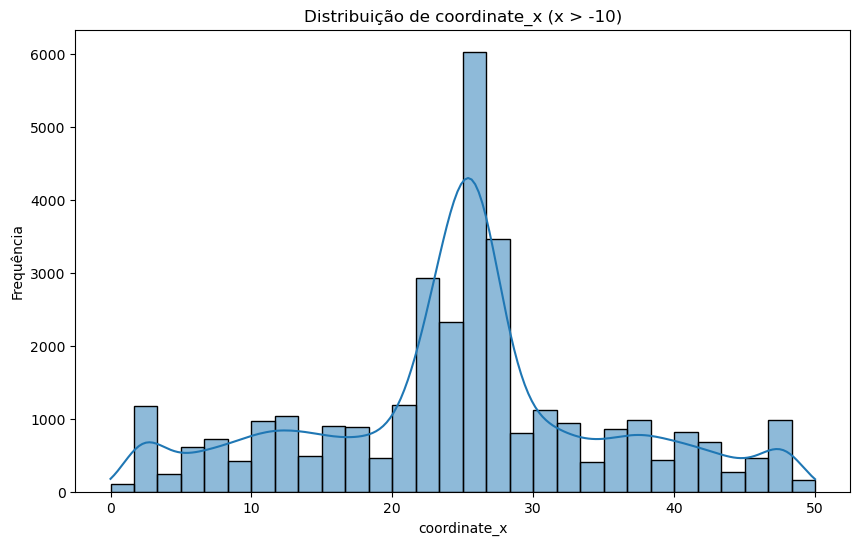

In [524]:
filtered_df = df[df['coordinate_x'] > -10]

plt.figure(figsize=(10, 6))
sns.histplot(filtered_df['coordinate_x'], bins=30, kde=True)
plt.title('Distribuição de coordinate_x (x > -10)')
plt.xlabel('coordinate_x')
plt.ylabel('Frequência')
plt.show()


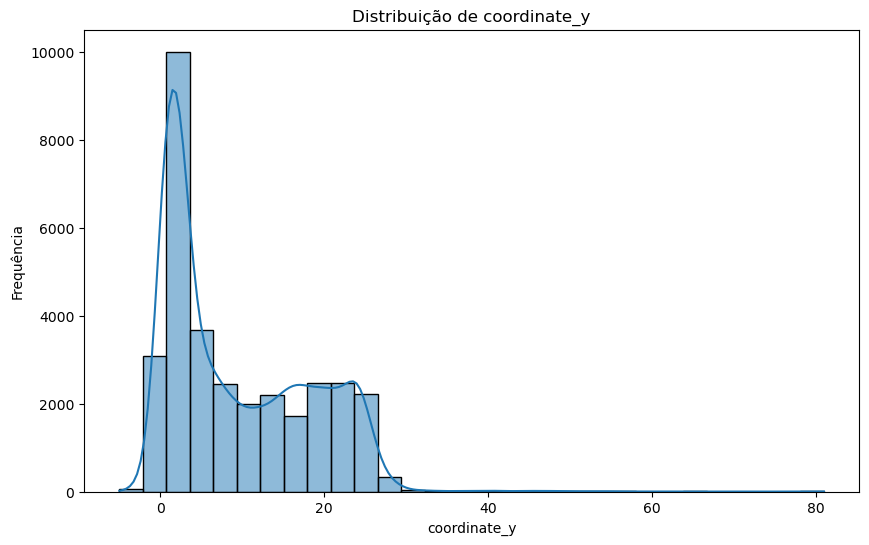

In [525]:
filtered_df = df[df['coordinate_y'] > -10]

plt.figure(figsize=(10, 6))
sns.histplot(filtered_df['coordinate_y'], bins=30, kde=True)
plt.title('Distribuição de coordinate_y')
plt.xlabel('coordinate_y')
plt.ylabel('Frequência')
plt.show()

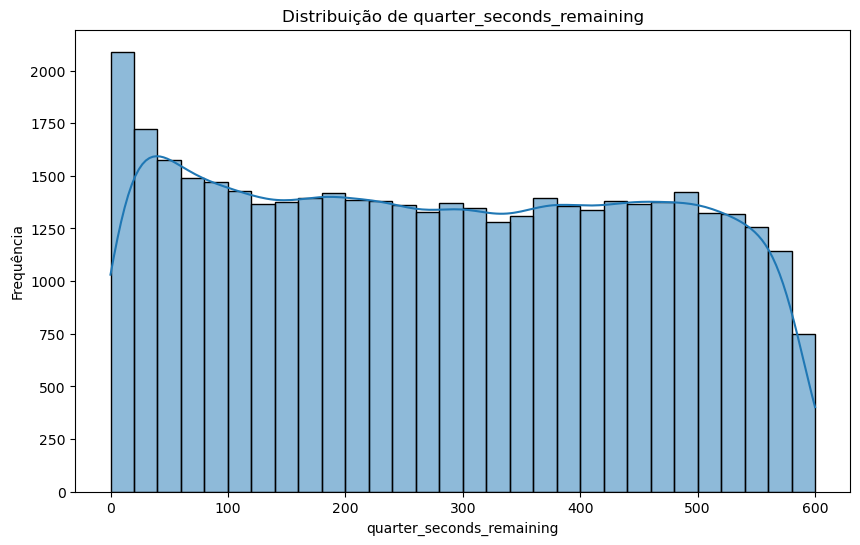

In [526]:
plt.figure(figsize=(10, 6))
sns.histplot(df['quarter_seconds_remaining'], bins=30, kde=True)
plt.title('Distribuição de quarter_seconds_remaining')
plt.xlabel('quarter_seconds_remaining')
plt.ylabel('Frequência')
plt.show()

In [527]:
df['distance_to_hoop'] = np.sqrt(df['coordinate_x']**2 + df['coordinate_y']**2)

bins = [0, 5, 10, 15, 20, 25, 30, 35]  # Intervalos de distância em pés/metros
df['distance_bin'] = pd.cut(df['distance_to_hoop'], bins=bins, labels=bins[:-1])
accuracy_by_distance = df.groupby('distance_bin')['made_shot'].mean()

/var/folders/vl/y_41x5_50d55msx55mh9_lk00000gn/T/ipykernel_1426/2954227165.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accuracy_by_distance = df.groupby('distance_bin')['made_shot'].mean()


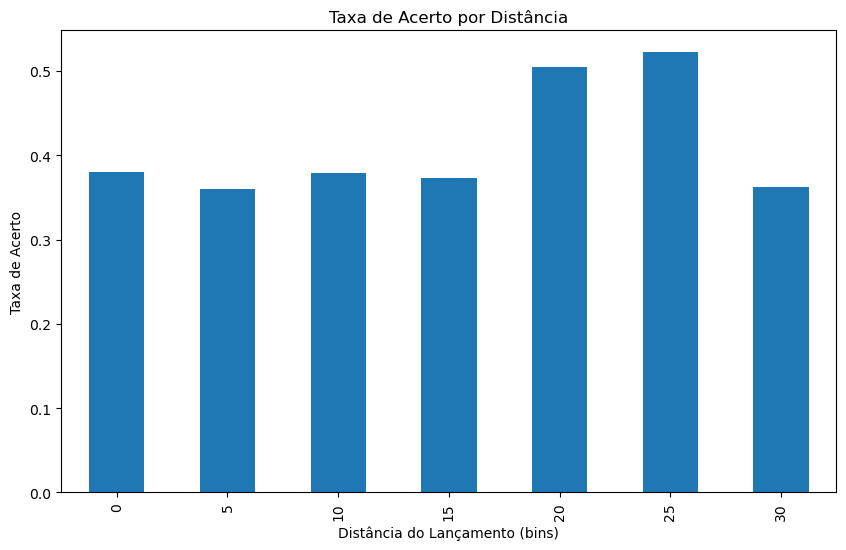

In [528]:
plt.figure(figsize=(10, 6))
accuracy_by_distance.plot(kind='bar')
plt.title('Taxa de Acerto por Distância')
plt.xlabel('Distância do Lançamento (bins)')
plt.ylabel('Taxa de Acerto')
plt.show()

- A taxa de acerto varia com a distância ao cesto, mas não apresenta uma relação linear clara:
  - **Pontos mais próximos (0-15):** Aqui a taxa de acerto é razoavelmente alta, mas não a maior, o que é esperado pois lançamentos mais próximos ao cesto têm maior probabilidade de sucesso no entanto há também muita defesa nestas áreas.
  - **Picos em 20-25 unidades:** Aqui a faixa de distância apresenta as maiores taxas de acerto, possivelmente representando a zona de lançamento ideal para jogadores, como a linha de 3 pontos ou lançamentos médios.
  - **Distâncias maiores (>30):** A taxa de acerto cai, indicando maior dificuldade em realizar lançamentos bem-sucedidos a partir de posições mais distantes.

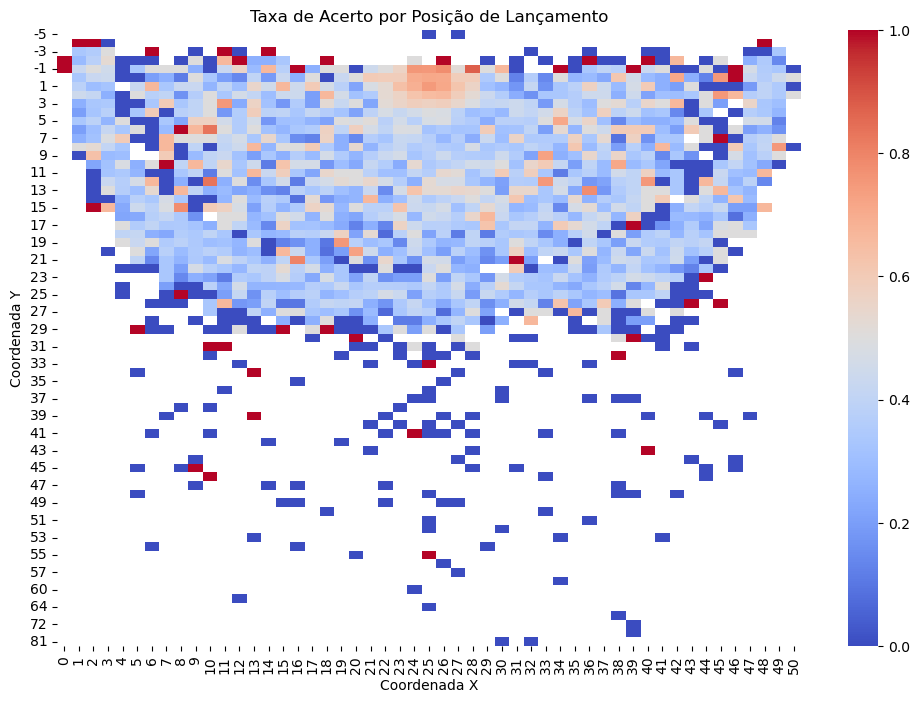

In [529]:
filtered_df = df[df['coordinate_y'] > -20]

heatmap_data = filtered_df.pivot_table(index='coordinate_y', columns='coordinate_x', values='made_shot', aggfunc='mean')
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', center=0.5)
plt.title('Taxa de Acerto por Posição de Lançamento')
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.show()

- O **centro do heatmap** (próximo ao cesto, com coordenadas X e Y mais baixas) apresenta altas taxas de acerto (valores em vermelho), indicando que os lançamentos nessa área têm maior probabilidade de sucesso.
- Áreas mais afastadas (em azul) apresentam baixas taxas de acerto, especialmente nas bordas superiores e inferiores do gráfico, o que reflete a dificuldade de lançamentos em posições extremas.
- Há **zonas específicas fora do cesto (valores médios)** que também mostram taxas de acerto razoáveis, possivelmente indicando zonas comuns de arremesso estratégico, como a linha de 3 pontos ou laterais próximas.

## Análise de Importância das Variáveis (Pre-Modelling XAI)

### **1.** Árvores de Decisão Simples

#### Treinar o Modelo

In [530]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

tree = DecisionTreeClassifier(max_depth=3, random_state=42)
X = df[['coordinate_x', 'coordinate_y', 'distance_to_hoop']]  # Exemplo de features
y = df['made_shot']
tree.fit(X, y)

DecisionTreeClassifier(max_depth=3, random_state=42)

#### Visualizar a Árvore

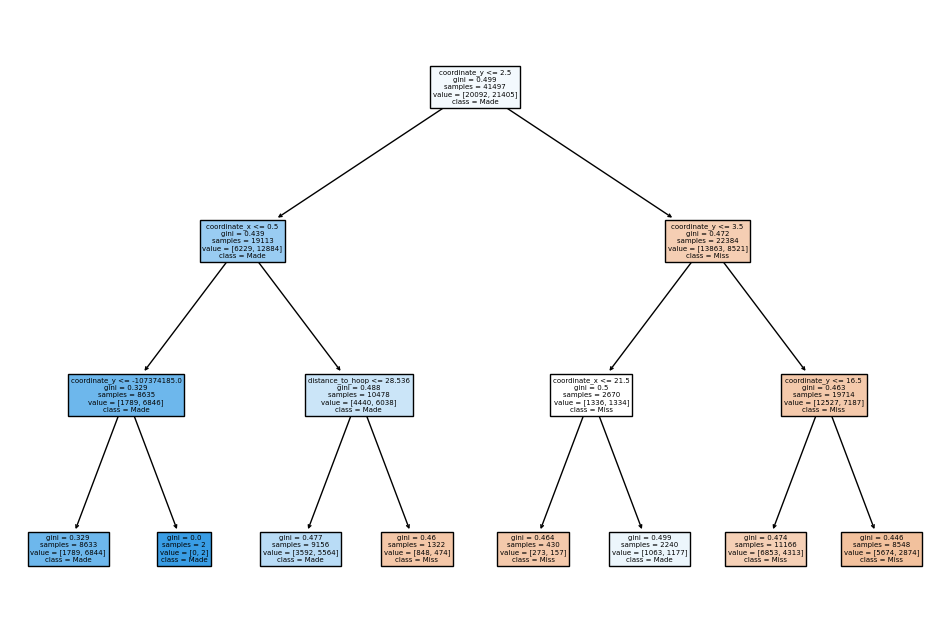

In [531]:
plt.figure(figsize=(12, 8))
plot_tree(tree, feature_names=X.columns, class_names=['Miss', 'Made'], filled=True)
plt.show()

#### Importância das Variáveis

In [532]:
importance = pd.Series(tree.feature_importances_, index=X.columns)
print(importance.sort_values(ascending=False))


coordinate_y        0.756774
coordinate_x        0.185665
distance_to_hoop    0.057560
dtype: float64


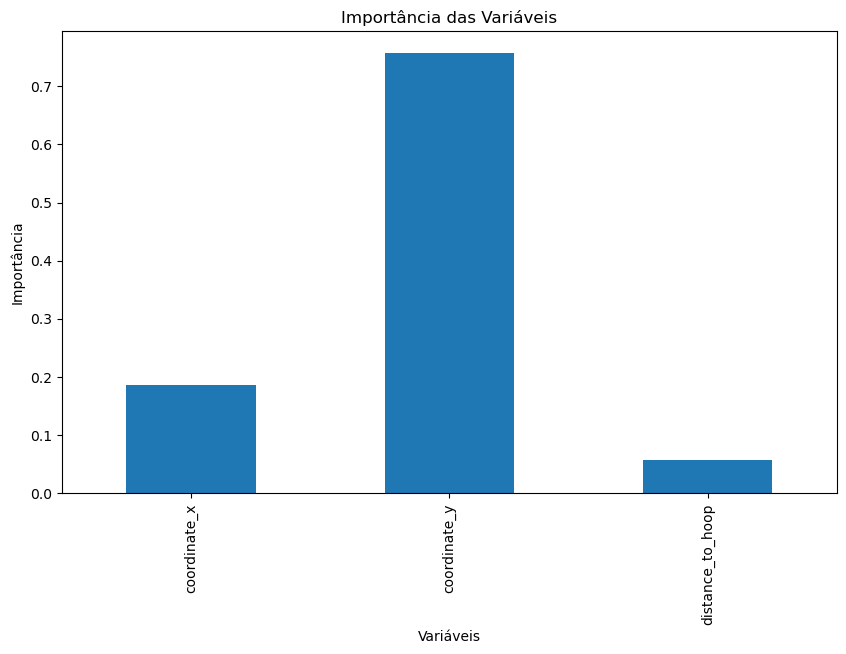

In [533]:
importance.plot(kind='bar', figsize=(10, 6))
plt.title('Importância das Variáveis')
plt.xlabel('Variáveis')
plt.ylabel('Importância')
plt.show()

- **Feature Importance:** As variáveis `coordinate_x`, `coordinate_y`, e `distance_to_hoop` são as principais determinantes do sucesso ou falha no lançamento.
- **Estrutura Hierárquica:** O modelo ao organizar as decisões inicialmente com divisões baseadas em `coordinate_x` e `coordinate_y` vem a indicar que estas coordenadas têm uma relação direta e forte com o resultado.

### **2.** Permutation Importance

#### Treinar o Modelo

In [534]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X, y)

LogisticRegression()

#### Calcular Permutation Importance

In [535]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X, y, scoring='accuracy', random_state=42)
importance = pd.DataFrame({'Feature': X.columns, 'Importance': perm_importance.importances_mean})
print(importance.sort_values(by='Importance', ascending=False))


            Feature  Importance
1      coordinate_y   -0.006453
0      coordinate_x   -0.041637
2  distance_to_hoop   -0.048244


#### Resultados

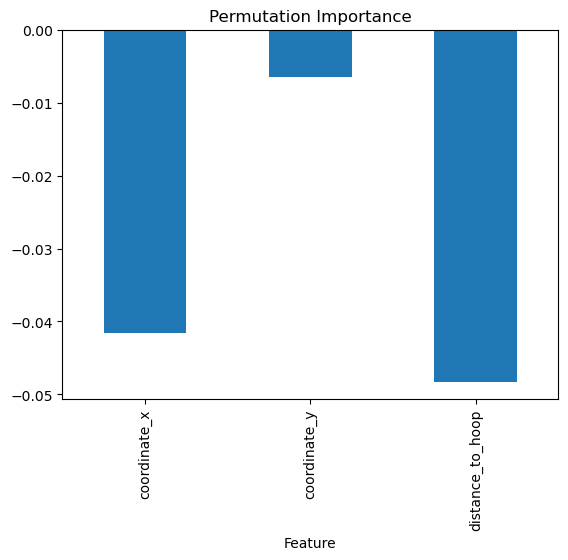

In [536]:
importance.plot.bar(x='Feature', y='Importance', legend=False)
plt.title('Permutation Importance')
plt.show()


- **Impacto Relativo das Variáveis:** A variável `distance_to_hoop` mostra uma importância negativa mais significativa, o que indica que quando os valores são embaralhados, a performance do modelo é mais afetada. Isso reafirma a sua relevância.
- `coordinate_x` e `coordinate_y` também são importantes, mas com menor impacto em relação a `distance_to_hoop`.

### **3.** SHAP (SHapley Additive Explanations)

#### Aplicar SHAP

In [537]:
import shap

explainer = shap.Explainer(model, X)
shap_values = explainer(X)

#### Resultados

##### Summary Plot: Mostra a contribuição média de cada variável.

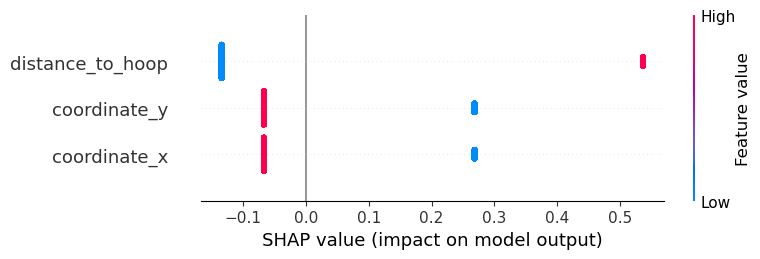

In [538]:
shap.summary_plot(shap_values, X)

- **Importância de `distance_to_hoop`:** A variável mais influente, com os valores mais altos de SHAP.
- **Interpretação de Valores:** Valores mais baixos de `distance_to_hoop` (menor distância ao cesto) estão associados a uma maior probabilidade de sucesso, enquanto valores mais altos reduzem as chances.
- **Relação entre Coordenadas:** Tanto `coordinate_x` quanto `coordinate_y` também têm impacto, mas são secundários. Tal como tinhamos visto.

| Técnica                     | Principal Conclusão                            |
|-----------------------------|-----------------------------------------------|
| **Árvore de Decisão**       | Simples e intuitiva, destaca coordenadas e distância. |
| **Permutation Importance**  | Confirma que `distance_to_hoop` é essencial.  |

# **Task 2**

## Modelagem Inicial e Explicações no Modelo

### Modelo Transparente (Glass-Box Model)

In [539]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Definir colunas numéricas e categóricas
numeric_cols = ['coordinate_x', 'coordinate_y', 'distance_to_hoop']
categorical_cols = []  # Adicione aqui as colunas categóricas, se houver

# Definir o pré-processador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ],
    remainder='passthrough'
)

# Criar o pipeline com o pré-processador e o modelo de Regressão Logística
glass_box_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Dividir os dados em conjuntos de treino e teste
X = df[['coordinate_x', 'coordinate_y', 'distance_to_hoop']]
y = df['made_shot']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar o modelo
glass_box_model.fit(X_train, y_train)

# Avaliar o modelo
accuracy = glass_box_model.score(X_test, y_test)
print(f'Acurácia do Glass-Box Model: {accuracy:.2f}')

Acurácia do Glass-Box Model: 0.61
